### （1） 机器阅读理解任务介绍

- 什么是机器阅读理解任务
    - 机器阅读理解（Machine Reading Comprehension，简称MRC）是是一项通过让机器回答基于给定上下文的问题来测试机器理解自然语言的程度的任务，简单来说即给定一个或者多个文档P，以及一个问题Q，输出问题Q的答案A。
    - 机器阅读理解任务的形式是较为多样化的，常见的类型包括（完型填空式、答案选择式的、片段抽取式的、自由生成式），本次课程讲解的内容为片段抽取式的机器阅读理解，即问题Q的答案A在文档P中，A是P中的一个连续片段。

- 机器阅读理解任务的样例
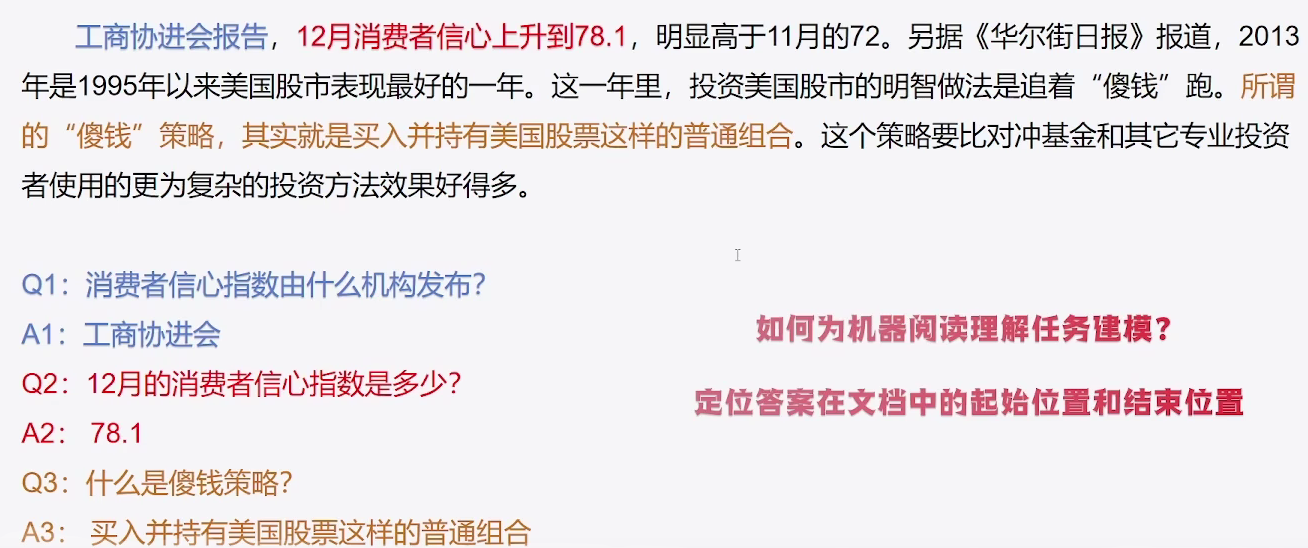

- 机器阅读理解数据集格式
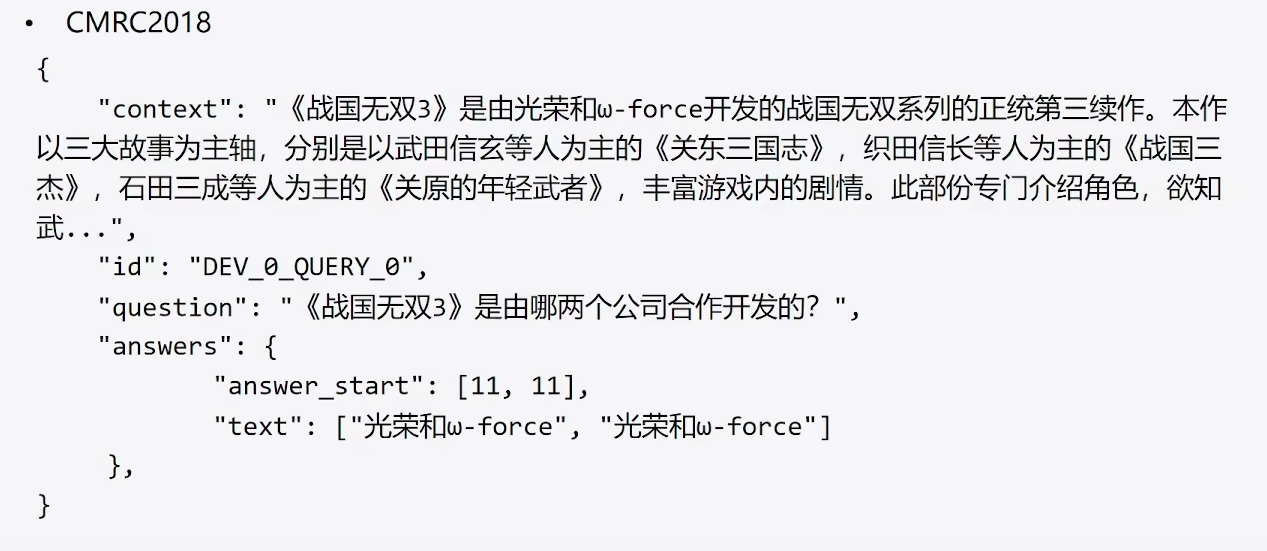

- 评估指标
    - 精准匹配度（Exact Match,EM）：计算预测结果与标准答案是否完全匹配
    - 模糊匹配度（F1）：计算预测结果与标准答案之间级别的匹配程度

- 简单示例
    - 数据
        - 模型预测结果:北京
        - 真实标签结果：北京天安门
    - 计算结果
        - EM=0，P=2/2 R=2/5 F1=(2*2/2*2/5)/(2/2+2/5)=4/7~=0.57

### （2）基于Transformers的解决方案

- 数据预处理
    - 数据处理格式
    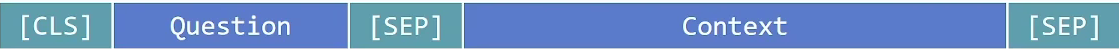
    - 如何确定答案位置
        - start_positions/end_positions
        - offset_mapping
    - Context过长如何解决
        - 策略1直接截断，简单易实现，但是会损失答案靠后的数据，因为无法定位答案
        - 策略2滑动窗口，实现较为复杂，会丢失部分上下文，但是综合来看损失较小

- 模型结构
    - *ModelForQuestionAnswering
    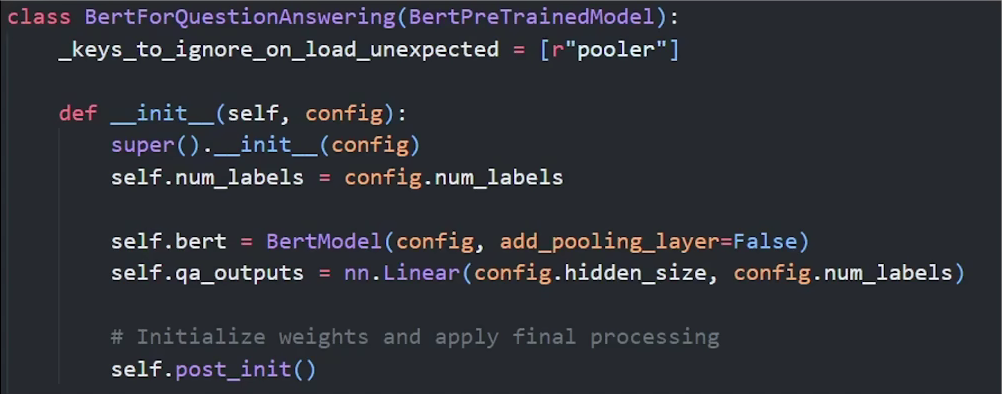
    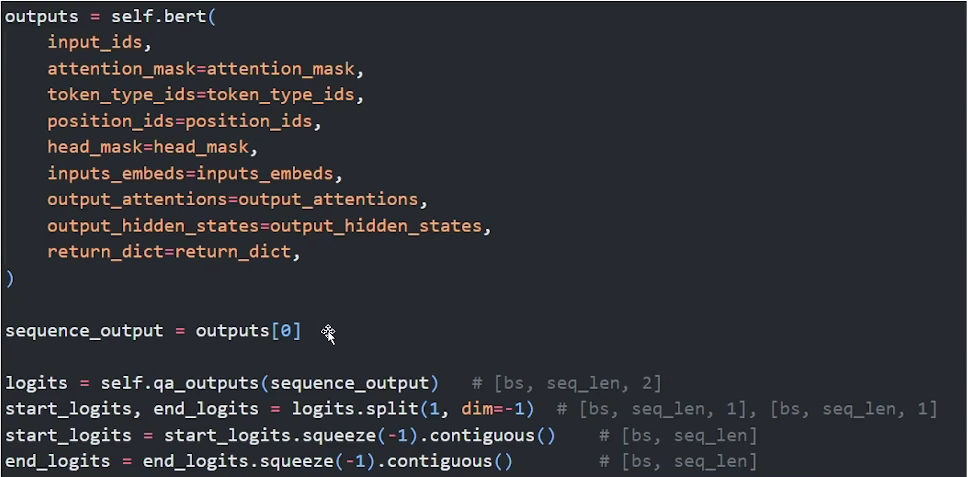
    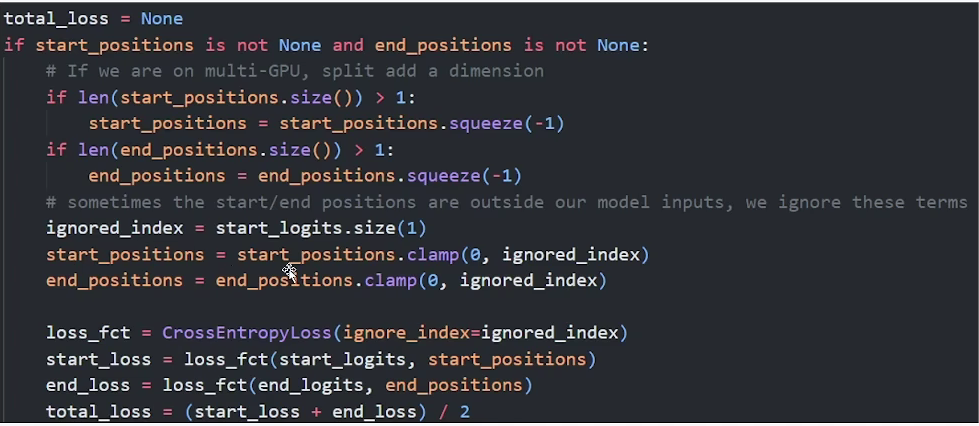

- 数据集
    - cmrc2018
- 预训练模型
    - hfl/chinese-macbert-base
- 数据集处理方式
    - 对context进行截断处理

### （3）代码实战演练（上，截断策略版本）

#### Step1 导入相关包

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer,AutoModelForQuestionAnswering,TrainingArguments,Trainer,DefaultDataCollator

#### Step2 数据集加载

In [ ]:
datasets=load_dataset('cmrc2018',cache_dir='data')

In [ ]:
datasets['train'][0]

#### Step3 数据预处理

In [ ]:
tokenizer=AutoTokenizer.from_pretrained('hfl/chinese-macbert-base')
tokenizer

In [ ]:
# 取10条数据
sample_dataset=datasets['train'].select(range(10))
sample_dataset

In [ ]:
# Tokenizer
# offset_mapping  描述文本中每个字符的偏移量
# 使用 tokenizer 函数对数据集进行标记化
tokenized_examples = tokenizer(
    text=sample_dataset['question'],          # 将问题文本标记化
    text_pair=sample_dataset['context'],      # 将上下文文本标记化
    return_offsets_mapping=True,              # 返回标记的偏移映射，用于后续定位标记在原始文本中的位置
    max_length=512,                           # 设置标记化后的最大长度为512
    truncation='only_second',                 # 仅在第二个文本（这里是上下文文本）进行截断
    padding=True                              # 对标记化后的序列进行填充，使它们的长度一致
)

# 查看 tokenized_examples 字典的键
tokenized_examples.keys()


In [ ]:
print(tokenized_examples['offset_mapping'][0],len(tokenized_examples['offset_mapping'][0]))

In [ ]:
# 看那个是文本，哪个是答案
(list(zip(tokenized_examples['input_ids'][0],tokenized_examples['token_type_ids'][0])))

In [ ]:
offset_mapping=tokenized_examples.pop('offset_mapping')
offset_mapping

In [ ]:
# 拿答案的起始位置
# 遍历偏移映射列表，获取答案在token中的起始和结束位置
for idx, offset in enumerate(offset_mapping):
    # 获取当前样本的答案信息
    answer = sample_dataset[idx]["answers"]
    
    # 答案在原始文本中的起始和结束字符位置
    start_char = answer["answer_start"][0]
    end_char = start_char + len(answer["text"][0])
    
    # 从左右两侧向答案位置逼近，以定位答案在token中的起始和结束位置
    context_start = tokenized_examples.sequence_ids(idx).index(1)#作用是找到第二个序列（上下文）的起始位置
    context_end = tokenized_examples.sequence_ids(idx).index(None, context_start) - 1#上下文序列在 sequence_ids 中的结束位置。
    
    # 判断答案是否在context范围内
    if offset[context_end][1] < start_char or offset[context_start][0] > end_char:
        start_token_pos = 0
        end_token_pos = 0
    else:
        # 从context_start开始向右找到答案的起始token位置
        token_id = context_start
        while token_id <= context_end and offset[token_id][0] < start_char:
            token_id += 1
        start_token_pos = token_id
        
        # 从context_end开始向左找到答案的结束token位置
        token_id = context_end
        while token_id >= context_start and offset[token_id][1] > end_char:
            token_id -= 1
        end_token_pos = token_id

    print(answer,start_char,end_char,context_start,context_end,start_token_pos,end_token_pos)
    print('token answer decode:',tokenizer.decode(tokenized_examples['input_ids'][idx][start_token_pos:end_token_pos+1]))

In [ ]:
# 预处理函数
def process_func(examples):
    tokenized_examples=tokenizer(text=examples['question'],
                             text_pair=examples['context'],
                             return_offsets_mapping=True,
                             max_length=512,
                             truncation='only_second',
                             padding=True)
    offset_mapping=tokenized_examples.pop('offset_mapping')
    start_positions=[]
    end_postitions=[]
    for idx,offset in enumerate(offset_mapping):
        answer=examples['answers'][idx]
        start_char=answer['answer_start'][0]
        end_char=start_char+len(answer['text'][0])

        # 定位答案在token中的起始位置和结束位置
        # 一种策略，我们要拿到context的起始和结束，然后从左右两侧向答案逼近
        context_start=tokenized_examples.sequence_ids(idx).index(1)
        context_end=tokenized_examples.sequence_ids(idx).index(None,context_start)-1

        # 判断答案是否在context中
        if offset[context_end][1]<start_char or offset[context_start][0]>end_char:
            start_token_pos=0
            end_token_pos=0
        else:
            token_id=context_start
            while token_id<=context_end and offset[token_id][0]<start_char:
                token_id+=1
            start_token_pos=token_id 
            token_id=context_end
            while token_id >= context_start and offset[token_id][1]>end_char:
                token_id-=1
            end_token_pos=token_id
        start_positions.append(start_token_pos)
        end_postitions.append(end_token_pos)
    
    tokenized_examples['start_positions']=start_positions
    tokenized_examples['end_postions']=end_postitions
    return tokenized_examples


In [ ]:
# 映射
tokenizer_datasets=datasets.map(process_func,batched=True,remove_columns=datasets['train'].column_names)

#### Step4 加载模型

In [ ]:
model=AutoModelForQuestionAnswering.from_pretrained('hfl/chinese-macbert-base')

#### Step5 配置TrainingArguments

In [ ]:
args=TrainingArguments(
    output_dir='models_for_qa',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    num_train_epochs=1

)

#### Step6 Trainer

In [ ]:
trainer=Trainer(
    model=model,
    args=args,
    train_dataset=tokenizer_datasets['train'],
    eval_dataset=tokenizer_datasets['validation'],
    data_collator=DefaultDataCollator(),
)

### Step7 模型训练

In [ ]:
trainer.train()

#### Step8 模型预测

In [ ]:
from transformers import pipeline
pipe=pipeline('question-answeing',model=model,tokenizer=tokenizer)
pipe

In [ ]:
pipe(question='小明在哪里上班？',context='小明在北京上班。')